# 机器学习训练营第一期大作业_EDA_Baseline #


* 本来我们最后选的比赛是，
https://www.kaggle.com/c/ga-customer-revenue-prediction


* 由于主办方给的数据出了问题，导致了泄漏leak，即选手们可以通过非建模方式，得到真实的预测值。
最近几天，主办方换了新的数据。
但是郁闷的是，数据从原来的1GB，换成了30GB的数据。
考虑到数据规模较大，很多同学可能无法正常操作，我们也在群里和同学们说明了情况，在此再次说明。


* 本来最后的final project也是本着让大家学习的目的，故我们重新为大家选了另外一个比赛，
    https://www.kaggle.com/c/instacart-market-basket-analysis
     并给出了一个EDA探索性分析，特征工程，建模，完整的流程。


* 进一步的学习和分析，可以参考下面链接。
    * 代码以及部分说明来自我们的一个队友（已授权），我们针对大家以及课程内容进行了修改，更加详细的内容大家可以参考：
    * https://github.com/dayeren/Kaggle_Competition_Treasure/tree/master/Recommendations/Instacart
    * https://mp.weixin.qq.com/s/nzLb8anROaUcfwfYiiQhzg
    
* 关于这两个比赛，我们都会给出指导，大家可以随时在圈子里提问，祝大家学习快乐~


# let's go

内容按下面组织，比较长。可以一段一段看。整个流程跑通，需要2个小时～2个半小时左右。

1  EDA（探索性分析）

 * 1.2.1  aisles数据集
 * 1.2.2  departments数据集
 * 1.2.3  products数据集
 * 1.2.4  oders数据集
 * 1.2.5  order_products_prior.csv数据集
 * 1.2.6  order_products_train.csv数据集

2 特征工程

* 用户特征
* 基于产品的特征
* 基于用户 + 产品的交叉特征

3 模型

* 构建训练集 & 测试集
* 模型验证
* 模型训练&提交




# 数据准备
## 工具包 & 数据导入
### 工具包导入

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
%matplotlib inline 

In [39]:
import warnings
warnings.filterwarnings("ignore")


### 数据导入
- 训练集测试集的导入

In [2]:
path = '/home/zhongrunxing/data/kaggle/market_basket/'
aisles = pd.read_csv(path + 'aisles.csv')
departments = pd.read_csv(path + 'departments.csv')
products = pd.read_csv(path + 'products.csv')
orders = pd.read_csv(path + 'orders.csv')
order_products__train = pd.read_csv(path + 'order_products__train.csv')
order_products__prior = pd.read_csv(path + 'order_products__prior.csv')

In [3]:
m1 = aisles.memory_usage().sum()
m2 = departments.memory_usage().sum()
m3 = products.memory_usage().sum()
m4 = orders.memory_usage().sum()
m5 = order_products__train.memory_usage().sum()
m6 = order_products__prior.memory_usage().sum()
print('total memory = {:,.0f} Bytes'.format(m1+m2+m3+m4+m5+m6))

total memory = 1,275,384,968 Bytes


# EDA

In [5]:
# 1.2.1  aisles数据集
# 我们先放一下重要的结论,有兴趣的可以自己往下看具体的分析.

# aisles的大小为134

# aisles中存在134个不一样的数据

In [6]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [7]:
aisles.shape

(134, 2)

In [8]:
aisles.nunique()

aisle_id    134
aisle       134
dtype: int64

In [9]:
# 1.2.2  departments数据集
# 我们先放一下重要的结论,有兴趣的可以自己往下看具体的分析.

# departments的大小为21

# departments中存在21个不一样的数据

In [10]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [11]:
departments.shape

(21, 2)

In [12]:
departments.nunique()

department_id    21
department       21
dtype: int64

In [13]:
# 我们先放一下重要的结论,有兴趣的可以自己往下看具体的分析.

# products数据集共有49688个值

# products中存在49688个不一样的数据

In [14]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [15]:
products.shape

(49688, 4)

In [16]:
products.nunique()

product_id       49688
product_name     49688
aisle_id           134
department_id       21
dtype: int64

In [17]:
# 1.2.4  oders数据集
# 我们先写一下重要的结论,有兴趣的可以自己往下看具体的分析.

# orders数据集共有3421083个样本，并且days_since_prior_order特征中出现了缺失值的情况。

# 我们发现,正如我们所料,所有的days_since_prior_order = NAN中order_number都是1,也就是第一单。

# order_number ==1的个数和用户个数是一样的,也就是说order_number是用户的购买顺序.每一次购买都会对应一个不同的订单号。

# user_id有206209个不同的值,eval_set,是一个categorical值,有3个不同的值。

# order_hour_of_day,order_hour_of_day属于正常值,一周7天,一天24小时。

# 一个用户最多有100条记录,最少有4条记录。

# 用户对应记录为4的次数最多,由4-100的次数逐次递减。

# eval_set是用来区分训练集&测试集&先验的,其中需要预测的test有75000个,prior中的类多了很多,这个时候需要考虑如何将prior和train进行拼接提取特征。

# 我们发现有75000个用户出现在了prior中,但是却未出现在train中。

# 训练集合中出现的用户在测试集中都未出现,但是却全部出现在了prior中。

# 所有的product_id都出现在训练集合中,所以不存在任何奇异值的情况。

# order_number存在时序关系,因为测试集和训练集不存在交集,我们发现训练集和测试集中的数据是最新的,所以我们的任务是预测未来用户会购买哪些产品.(order_number_max的值都出现在了训练集&测试集中)

In [18]:
# 1.orders数据集共有3421083个样本，并且days_since_prior_order特征中出现了缺失值的情况.
# (因为数据的特征是存在物理含义的,所以此时我们得看一下为什么存在缺失的情况,可能是因为第一个订单,所以在此之前是不存在订单的.)
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [19]:
orders.shape

(3421083, 7)

In [20]:
# 2.我们发现,正如我们所料,所有的days_since_prior_order = NAN中order_number都是1,
# 也就是第一单,因而不存在上一单,这个时候我们如果我们采用树模型解决该问题,那么尽量不要将缺失值进行填充,
# 或者填充为其他较大值为好.(因为填充-1等较小值,模型往往可能认为购买的时间较近)

In [21]:
orders.loc[orders.days_since_prior_order.isnull()].head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
11,2168274,2,prior,1,2,11,NaN
26,1374495,3,prior,1,1,14,NaN
39,3343014,4,prior,1,6,11,NaN
45,2717275,5,prior,1,3,12,NaN
50,2086598,6,prior,1,5,18,NaN
54,2565571,7,prior,1,3,9,NaN
75,600894,8,prior,1,6,0,NaN
79,280530,9,prior,1,1,17,NaN
83,1224907,10,prior,1,2,14,NaN


In [22]:
# 3.order_number ==1的个数和用户个数是一样的,也就是说order_number是用户的购买顺序.每一次购买都会对应一个不同的订单号。

In [ ]:
# 4.user_id有206209个不同的值,eval_set,是一个categorical值,有3个不同的值。

In [23]:
print('There are  %d samples with order_number=1 ' % np.sum(orders['order_number'] == 1))

There are  206209 samples with order_number=1 


In [24]:
orders.nunique()

order_id                  3421083
user_id                    206209
eval_set                        3
order_number                  100
order_dow                       7
order_hour_of_day              24
days_since_prior_order         31
dtype: int64

In [25]:
orders.groupby('user_id')['order_number'].min().sort_values(ascending = False)

user_id
206209    1
68732     1
68742     1
68741     1
68740     1
68739     1
68738     1
68737     1
68736     1
68735     1
68734     1
68733     1
68731     1
68769     1
68730     1
68729     1
68728     1
68727     1
68726     1
68725     1
68724     1
68723     1
68722     1
68721     1
68743     1
68744     1
68745     1
68746     1
68767     1
68766     1
         ..
137445    1
137444    1
137443    1
137442    1
137463    1
137465    1
137488    1
137466    1
137487    1
137486    1
137485    1
137484    1
137483    1
137482    1
137481    1
137480    1
137479    1
137478    1
137477    1
137476    1
137475    1
137474    1
137473    1
137472    1
137471    1
137470    1
137469    1
137468    1
137467    1
1         1
Name: order_number, Length: 206209, dtype: int64

In [26]:
# 基于上面的信息,我们再来看几个简单的类别特征,这里主要是为了获取一些基础的信息,同时查看是否存在一些奇异值。

In [27]:
# 5.order_hour_of_day,order_hour_of_day属于正常值,一周7天,一天24小时

In [28]:
orders[['order_dow','order_hour_of_day']].describe()

,order_dow,order_hour_of_day
count,3.421083e+06,3.421083e+06
mean,2.776219e+00,1.345202e+01
std,2.046829e+00,4.226088e+00
min,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+01
50%,3.000000e+00,1.300000e+01
75%,5.000000e+00,1.600000e+01
max,6.000000e+00,2.300000e+01


In [30]:
# 6.一个用户最多有100条记录,最少有4条记录.
# 因为value_counts默认是递减排序的,我们发现一个用户的订单个数最多是100,最少是4。

In [31]:
orders['user_id'].value_counts()[:5]

53684     100
201623    100
50817     100
176951    100
88911     100
Name: user_id, dtype: int64

In [33]:
orders['user_id'].value_counts()[-5:]

24224     4
199509    4
32420     4
21310     4
196830    4
Name: user_id, dtype: int64

In [34]:
# 7.用户对应记录为4的次数最多,由4-100的次数逐次递减。

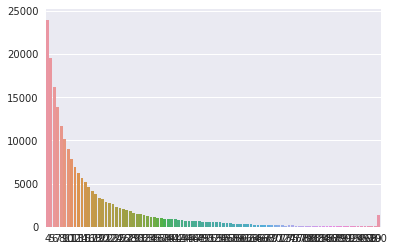

In [40]:
tmp = pd.DataFrame(orders['user_id'].value_counts().values,
                   columns = ['user_correspoding_samples'])
tmp = tmp['user_correspoding_samples'].value_counts()
sns.barplot(x =  tmp.index, y =tmp.values)

In [42]:
# 8.eval_set是用来区分训练集&测试集&先验的,其中需要预测的test有75000个,
# prior中的类多了很多,这个时候需要考虑如何将prior和train进行拼接提取特征。

In [43]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [44]:
# 下面我看一下prior,train,test中用户的交叉情况,因为用户在所有的推荐问题中都将是一个极为重要的特征变量。

In [45]:
# 9.我们发现有75000个用户出现在了prior中,但是却未出现在train中。

In [46]:
len(set(orders.loc[orders['eval_set']=='prior','user_id']) - set(orders.loc[orders['eval_set']=='train','user_id']))

75000

In [47]:
len(set(orders.loc[orders['eval_set']=='train','user_id']))

131209

In [48]:
# 10.训练集合中出现的用户在测试集中都未出现,但是却全部出现在了prior中。
# 这点很重要,这也意味着用户的id编码在模型预测时,可能并不能带来增益,可以考虑删除.

In [49]:
len(set(orders.loc[orders['eval_set']=='train','user_id']) - set(orders.loc[orders['eval_set']=='test','user_id']))

131209

In [50]:
len(set(orders.loc[orders['eval_set']=='test','user_id']) - set(orders.loc[orders['eval_set']=='prior','user_id']))

0

In [51]:
# 11.所有的product_id都出现在训练集合中,所以不存在任何奇异值的情况

In [52]:
set(order_products__prior['product_id'].values) - set(products['product_id'].values)


set()

In [53]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [54]:
# 我们再看一下order_number与订单的关系，我们发现:

# 12.order_number存在时序关系,因为测试集和训练集不存在交集,我们发现训练集和测试集中的数据是最新的,
# 所以我们的任务是预测未来用户会购买哪些产品.(order_number_max的值都出现在了训练集&测试集中)

In [55]:
orders['order_number_max'] = orders.groupby('user_id')['order_number'].transform('max').values
orders.loc[orders.order_number!=orders.order_number_max,'eval_set'].value_counts()

prior    3214874
Name: eval_set, dtype: int64

In [56]:
orders.loc[orders.order_number==orders.order_number_max,'eval_set'].value_counts()

train    131209
test      75000
Name: eval_set, dtype: int64

In [57]:
# 1.2.5  order_products_prior.csv数据集
# 下面我们再看一下order_products__prior数据集。

# 一个order_id对应多个product_id,一个订单里面有很多产品,这很符合我们的购物经验。

# order_products__prior数据集共有32434489个样本。

# order_id有3214874个不同的,和之前的orders是一致的。

# reordered的均值是0.58967,也就是说有大概42%的数据是没记录的,剩下的都是之前有买过的。

# 添加到购物篮清单顺序,从1-145次数依次递减,符合实际情况,并无异常值,但是我们发现加入到篮子中的顺序越大,产品越少。和我们的直觉也是一样的。

In [59]:
# 1.一个order_id对应多个product_id,一个订单里面有很多产品,这很符合我们的购物经验.

In [60]:
# 2.order_products__prior数据集共有32434489个样本

In [61]:
order_products__prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [62]:
order_products__prior.shape

(32434489, 4)

In [ ]:
# 3.order_id有3214874个不同的,和之前的orders是一致的

In [ ]:
# 4.reordered的均值是0.58967,也就是说有大概42%的数据是没记录的,剩下的都是之前有买过的.

In [63]:
order_products__prior.nunique()

order_id             3214874
product_id             49677
add_to_cart_order        145
reordered                  2
dtype: int64

In [64]:
order_products__prior['reordered'].mean()

0.5896974667922161

In [65]:
# 5.添加到购物篮清单顺序,从1-145次数依次递减,符合实际情况,并无异常值,
# 但是我们发现加入到篮子中的顺序越大,产品越少。和我们的直觉也是一样的。

In [66]:
order_products__prior['add_to_cart_order'].value_counts()

1      3214874
2      3058126
3      2871133
4      2664106
5      2442025
6      2213695
7      1986020
8      1766014
9      1562640
10     1378293
11     1212743
12     1065282
13      933702
14      816831
15      713148
16      621504
17      540312
18      468952
19      406323
20      351506
21      303410
22      261547
23      225179
24      193507
25      166442
26      142829
27      122546
28      105058
29       89956
30       76923
        ...   
116          5
117          4
118          4
119          4
120          4
121          4
124          3
125          3
127          3
126          3
123          3
122          3
128          2
129          2
130          2
131          2
132          2
133          2
134          2
135          2
136          2
137          2
143          1
141          1
142          1
144          1
140          1
139          1
138          1
145          1
Name: add_to_cart_order, Length: 145, dtype: int64

In [67]:
tmp = pd.DataFrame(order_products__prior['add_to_cart_order'].value_counts().sort_index())
tmp.head()

,add_to_cart_order
1,3214874
2,3058126
3,2871133
4,2664106
5,2442025


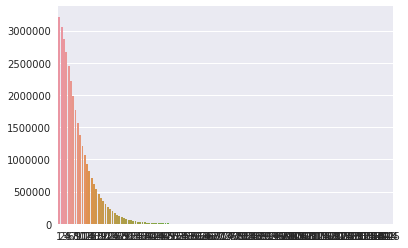

In [69]:
sns.barplot(x =  tmp.index.values, y =tmp.values[:,0])

In [71]:
# 1.2.6  order_products_train.csv数据集
# order_products__train共有1384617个样本

# order_id有131209个不同的,都包含再之前的orders是一致的

# reordered的均值是0.59859,也就是说有大概40%的数据是没记录的

# 添加到购物篮清单顺序,从1-80次数依次递减,符合实际情况,并无异常值

# 所有的product_id都出现在训练集合中,所以不存在任何奇异值的情况

In [72]:
# 1.order_products__train共有1384617个样本

In [73]:
order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [74]:
order_products__train.shape

(1384617, 4)

In [75]:
# 2.order_id有131209个不同的,都包含再之前的orders是一致的

In [76]:
# 3.reordered的均值是0.59859,也就是说有大概40%的数据是没记录的

In [77]:
order_products__train.nunique()

order_id             131209
product_id            39123
add_to_cart_order        80
reordered                 2
dtype: int64

In [78]:
order_products__train['reordered'].mean()

0.5985944127509629

In [79]:
tmp = pd.DataFrame(order_products__prior['add_to_cart_order'].value_counts().sort_index())
tmp.head()

,add_to_cart_order
1,3214874
2,3058126
3,2871133
4,2664106
5,2442025


In [80]:
# 4.添加到购物篮清单顺序,从1-80次数依次递减,符合实际情况,并无异常值

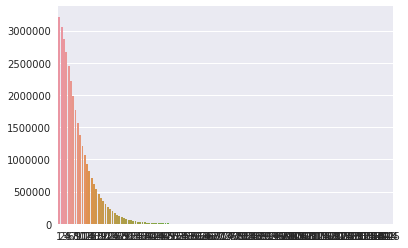

In [81]:
sns.barplot(x =  tmp.index.values, y =tmp.values[:,0])

In [82]:
# 5.所有的product_id都出现在训练集合中,所以不存在任何奇异值的情况

In [83]:
set(order_products__train['product_id'].values) - set(products['product_id'].values)


set()

In [84]:
len(set(order_products__train['order_id'] ) -set(order_products__prior['order_id'] )  )


131209

# end of EDA

# 特征工程

目前很多比赛都还是特征为王的比赛，针对许多传统的比赛，因为存在很多封装好的工具包,例如XGBoost,LightGBM等工具包,所以很多做数据分析建模或者数据竞赛的人的任务往往就会相对简单，这个时候因为模型变化不大,那么我们的任务往往就会演变为两大模块,特征工程+集成，而特征工程又很难找到非常好的书籍进行系统的学习,所以很多时候网上也都将特征工程称之为艺术。

闲话不多说,下面我们还是以推荐问题为例,介绍基本的推荐算法的特征工程。

我们将该赛题的特征工程粗分为下面几个模块。

1. 用户特征;
2. 产品特征;
3. 用户产品特征;


## 用户特征 

In [85]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_number_max
0,2539329,1,prior,1,2,8,NaN,11
1,2398795,1,prior,2,3,7,15.0,11
2,473747,1,prior,3,3,12,21.0,11
3,2254736,1,prior,4,4,7,29.0,11
4,431534,1,prior,5,4,15,28.0,11


### 用户购物的总次数

In [86]:
user_fea = pd.DataFrame()
user_fea['user_id'] = orders['user_id'].unique()
user_fea = user_fea[['user_id']].sort_values('user_id')

In [87]:
user_fea['user_orderid_count'] = orders.groupby('user_id')['order_id'].count().values 

### 用户购物频繁度

1. 如果用户平均相隔天数少,往往说明用户是爱频繁购物的，那么他很有可能会不断地去消费某些产品;
2. 如果用户距离上次的购物最大天数都很小,那么往往说明客户是非常爱购物的,和均值特征是类似的一种.
3. 如果用户距离上次购物的时间的方差较小,说明用户购物有较强的周期性.
4. 同样的,用户距离上一次购买产品的众数也是此类特征之一.

In [88]:
user_fea['user_days_since_prior_order_mean'] = orders.groupby('user_id')['days_since_prior_order'].mean().values
user_fea['user_days_since_prior_order_max'] = orders.groupby('user_id')['days_since_prior_order'].max().values
user_fea['user_days_since_prior_order_std'] = orders.groupby('user_id')['days_since_prior_order'].std().values

In [89]:
user_fea['user_days_since_prior_order_mode'] = orders.groupby('user_id')['days_since_prior_order'].apply(lambda x: x.mode()[0]).values

### 用户时间喜好
- 不同用户购物的时间往往不同,很多用户喜欢深夜购物,有的用户则往往喜欢周五购物,这些不同的时间点往往也是一个非常重要的选择,比如有些用户喜欢周五买香蕉什么的生活习惯,可以对预测带来非常大的帮助。有人则喜欢深夜购物等等。

In [90]:
user_fea['user_order_dow_mode']         = orders.groupby('user_id')['order_dow'].apply(lambda x: x.mode()[0]).values
user_fea['user_order_hour_of_day_mode'] = orders.groupby('user_id')['order_hour_of_day'].apply(lambda x: x.mode()[0]).values

- 补充上一个二阶的用户时间喜好特征,用来表示用户喜欢在每周晚上几点开始购物.

In [91]:
orders['dow_hour'] = orders['order_dow'].values * 25 + orders['order_hour_of_day'].values
user_fea['user_dow_hour_mode'] = orders.groupby('user_id')['dow_hour'].apply(lambda x: x.mode()[0]).values

### 用户商品喜好特征
- 注意此处我们以priors的数据集进行商品特征的提取,**可能很多人会认为为什么不结合train一起提取特征**,这样数据量更大,这主要是考虑到test中并无类似的特征,而且test中的用户又未出现在train中,所以这样提取的特征是有些问题的,因为训练集中的特征来源于priors & train,但是test却只能来源于prior,所以可能造成偏差。

此处我们用如下的几类特征来表示用户商品的特征.
1. 用户购买不同产品的数量
2. 用户购买最多的三种产品,如果用户只购买了两类产品,那么最后一种产品我们用-1来表示.
3. 用户购买所有产品的数量
4. 用户平均每一单购买的产品数量

In [92]:
order_products__prior_ = order_products__prior.merge(orders, on='order_id', how = 'left')

In [93]:
user_fea['user_product_nunique'] = order_products__prior_.groupby('user_id')['product_id'].nunique().sort_index().values

In [94]:
def mode_N(x,i):
    m = x.value_counts().index
    if len(m) > i: 
        return m[i] 
    return -1
user_fea['user_product_mode'] = order_products__prior_.groupby('user_id')['product_id'].apply(lambda x: x.mode()[0]).sort_index().values
user_fea['user_product_mode_1'] = order_products__prior_.groupby('user_id')['product_id'].apply(lambda x: mode_N(x,1)).sort_index().values 
user_fea['user_product_mode_2'] = order_products__prior_.groupby('user_id')['product_id'].apply(lambda x: mode_N(x,2)).sort_index().values

In [95]:
user_fea['user_product_count'] = order_products__prior_.groupby('user_id')['product_id'].count().sort_index().values

In [96]:
user_fea['user_product_orderid_ratio'] = user_fea['user_product_count'] / user_fea['user_orderid_count']

### 用户购物疯狂性特征
1. 用户订单中的商品最多数
2. 用户每次平均购买的商品量
3. 用户购买商品的1/4,3/4位数

In [97]:
tmp = order_products__prior_.groupby(['user_id','order_id'])['add_to_cart_order'].max().reset_index()

In [98]:
user_fea['user_add_to_cart_order_max'] = tmp.groupby('user_id')['add_to_cart_order'].max().sort_index().values
user_fea['user_add_to_cart_order_mean'] = tmp.groupby('user_id')['add_to_cart_order'].mean().sort_index().values
user_fea['user_add_to_cart_order_quantile_25'] = tmp.groupby('user_id')['add_to_cart_order'].quantile().sort_index().values
user_fea['user_add_to_cart_order_quantile_75'] = tmp.groupby('user_id')['add_to_cart_order'].quantile(0.75).sort_index().values

In [99]:
del tmp
gc.collect()

102

### 用户购买商品的重构率

我们用用户购买的所有商品中的重新购买的和以及均值来表示

In [100]:
user_fea['user_reordered_sum'] = order_products__prior_.groupby('user_id')['reordered'].sum().sort_index().values
user_fea['user_reordered_mean'] = order_products__prior_.groupby('user_id')['reordered'].mean().sort_index().values

## 基于产品的特征

上面我们对用户特征进行了简单的提取,分别针对用户的购买时间偏好,用户对商品的喜好,重构的情况等等出发进行特征的构建。

下面我们从商品的特征出发进行商品特征的构建。虽然下面的特征都可以认为是产品的热度&受欢迎度特征等,但我们还是尽可能将其分开解释。

### 产品的热度
1. 产品被买多少次
2. 产品被多少不同用户所购买
3. 产品被添加到篮子中的顺序的均值 & 标准差

In [101]:
product_fea = pd.DataFrame()
product_fea['product_id'] = order_products__prior_['product_id'].unique() 
product_fea= product_fea.sort_values('product_id')

In [102]:
product_fea['product_count'] = order_products__prior_.groupby('product_id')['user_id'].count().sort_index().values

In [103]:
product_fea['product_order_nunqiue'] = order_products__prior_.groupby('product_id')['order_id'].nunique().sort_index().values
product_fea['product_user_nunqiue']  = order_products__prior_.groupby('product_id')['user_id'].nunique().sort_index().values

In [104]:
product_fea['product_add_to_cart_order_mean'] = order_products__prior_.groupby('product_id')['add_to_cart_order'].mean().sort_index().values 
product_fea['product_add_to_cart_order_std']  = order_products__prior_.groupby('product_id')['add_to_cart_order'].std().sort_index().values 

### 产品受欢迎的时间段
1. 产品被购买最多的两天
2. 产品被购买最多的两个小时段
3. 产品被购买距离上次购买最多的两个时间段
4. 产品距离上次被购买的均值以及均方差

In [105]:
product_fea['product_dow_mode'] = order_products__prior_.groupby('product_id')['order_dow'].apply(lambda x: x.mode()[0]).sort_index().values
product_fea['product_dow_mode_1'] = order_products__prior_.groupby('product_id')['order_dow'].apply(lambda x: mode_N(x,1)).sort_index().values

In [106]:
product_fea['product_hour_of_day_mode'] = order_products__prior_.groupby('product_id')['order_hour_of_day'].apply(lambda x: x.mode()[0]).sort_index().values
product_fea['product_hour_of_day_mode_1'] = order_products__prior_.groupby('product_id')['order_hour_of_day'].apply(lambda x: mode_N(x,1)).sort_index().values

In [107]:
product_fea['product_days_since_prior_order_mode'] = order_products__prior_.groupby('product_id')['days_since_prior_order'].apply(lambda x: mode_N(x,0)).sort_index().values
product_fea['product_days_since_prior_order_mode_1'] = order_products__prior_.groupby('product_id')['days_since_prior_order'].apply(lambda x: mode_N(x,1)).sort_index().values

In [108]:
product_fea['product_dow_hour_mode'] = order_products__prior_.groupby('product_id')['dow_hour'].apply(lambda x: mode_N(x,0)).sort_index().values
product_fea['product_dow_hour_mode_1'] = order_products__prior_.groupby('product_id')['dow_hour'].apply(lambda x: mode_N(x,1)).sort_index().values

In [109]:
product_fea['product_days_since_prior_order_mean'] = order_products__prior_.groupby('product_id')['days_since_prior_order'].mean().sort_index().values 
product_fea['product_days_since_prior_order_std'] = order_products__prior_.groupby('product_id')['days_since_prior_order'].std().sort_index().values 

### 产品的被重购率

产品的重构率,标准差以及和。

In [110]:
product_fea['product_reordered_mean'] = order_products__prior_.groupby('product_id')['reordered'].mean().sort_index().values 
product_fea['product_reordered_std'] = order_products__prior_.groupby('product_id')['reordered'].std().sort_index().values 
product_fea['product_reordered_sum'] = order_products__prior_.groupby('product_id')['reordered'].sum().sort_index().values 

## 基于用户 + 产品的交叉特征

In [111]:
order_products__prior_['user_product'] = order_products__prior_['user_id'].values * 10**5 + order_products__prior_['product_id'].values

In [112]:
userXproduct_fea = pd.DataFrame()
userXproduct_fea['user_product'] = order_products__prior_['user_product'].unique() 
userXproduct_fea = userXproduct_fea[['user_product']].sort_values('user_product')

**此处的用户和产品的交叉特征,我们就用下面几个简单特征进行表述**:
1. 同一用户对某一个产品的重构率;
2. 同一用户对某一个产品的加入篮子的顺序的和以及均值;
3. 同一用户购买某一个产品的次数

In [113]:
userXproduct_fea['user_product_reordered_sum'] = order_products__prior_.groupby('user_product')['reordered'].sum().sort_index().values 

In [114]:
userXproduct_fea['user_product_add_to_cart_order_sum']   = order_products__prior_.groupby('user_product')['add_to_cart_order'].sum().sort_index().values 
userXproduct_fea['user_product_add_to_cart_order_mean']   = order_products__prior_.groupby('user_product')['add_to_cart_order'].mean().sort_index().values 

In [115]:
userXproduct_fea['user_product_order_nunique']   = order_products__prior_.groupby('user_product')['order_id'].nunique().sort_index().values 

In [116]:
userXproduct_fea['user_product_last_order_num'] = order_products__prior_.groupby('user_product')['order_number'].max().sort_index().values 

In [117]:
userXproduct_fea.head()

,user_product,user_product_reordered_sum,user_product_add_to_cart_order_sum,user_product_add_to_cart_order_mean,user_product_order_nunique,user_product_last_order_num
3105781,100196,9,14,1.400000,10,10
3105783,110258,8,30,3.333333,9,10
3105785,110326,0,5,5.000000,1,5
3105782,112427,9,33,3.300000,10,10
3767345,113032,2,19,6.333333,3,10


# 构建训练集 & 测试集
具体的构建原理此处就不再阐述,具体的可以参见前一篇文章的内容:Instacart Market Basket Analysis：数据探索分析&Baseline(0.2428)

In [118]:
orders_prior_data = orders.loc[orders.eval_set == 'prior']
orders_train_data = orders.loc[orders.eval_set == 'train'] 
orders_test_data  = orders.loc[orders.eval_set == 'test' ] 

priors = order_products__prior.merge(orders_prior_data, on =['order_id'], how='left')
trains = order_products__train.merge(orders_train_data, on =['order_id'], how='left')

In [119]:
user_product = order_products__prior_[['user_id','product_id']].copy()
user_product['user_X_product'] = user_product['user_id'].values* 10**5  + user_product['product_id'].values
train_user_X_product = trains['user_id'].values* 10**5 + trains['product_id'].values

In [120]:
user_product = user_product.drop_duplicates(subset=['user_X_product'], keep = 'last') 

In [121]:
test_user  = orders_test_data['user_id']
train_user = orders_train_data['user_id']

In [122]:
user_product['label'] = 0
train_data = user_product.loc[user_product.user_id.isin(train_user)]
train_data.loc[train_data.user_X_product.isin(train_user_X_product), 'label'] = 1 

In [123]:
train_data['label'].sum()

828824

In [124]:
train_data['label'].mean()

0.09780025419305857

In [125]:
train_data = train_data.merge(orders_train_data,on ='user_id', how='left')

In [126]:
test_data  = user_product.loc[user_product.user_id.isin(test_user)]
test_data = test_data.merge(orders_test_data,on ='user_id', how='left')

## 特征拼接

- orders的数据合并

In [127]:
train_data = train_data.merge(user_fea, on='user_id', how='left')
train_data = train_data.merge(product_fea, on='product_id', how='left')
train_data = train_data.merge(userXproduct_fea, left_on='user_X_product', right_on='user_product', how='left')
train_data = train_data.merge(products, on='product_id', how= 'left')

In [128]:
pd.set_option('display.max_columns',50)
train_data.head()

,user_id,product_id,user_X_product,label,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_number_max,dow_hour,user_orderid_count,user_days_since_prior_order_mean,user_days_since_prior_order_max,user_days_since_prior_order_std,user_days_since_prior_order_mode,user_order_dow_mode,user_order_hour_of_day_mode,user_dow_hour_mode,user_product_nunique,user_product_mode,user_product_mode_1,user_product_mode_2,user_product_count,...,product_user_nunqiue,product_add_to_cart_order_mean,product_add_to_cart_order_std,product_dow_mode,product_dow_mode_1,product_hour_of_day_mode,product_hour_of_day_mode_1,product_days_since_prior_order_mode,product_days_since_prior_order_mode_1,product_dow_hour_mode,product_dow_hour_mode_1,product_days_since_prior_order_mean,product_days_since_prior_order_std,product_reordered_mean,product_reordered_std,product_reordered_sum,user_product,user_product_reordered_sum,user_product_add_to_cart_order_sum,user_product_add_to_cart_order_mean,user_product_order_nunique,user_product_last_order_num,product_name,aisle_id,department_id
0,202279,9327,20227909327,0,1050357,train,9,1,14,30.0,9,39,9,22.625000,30.0,9.455724,30.0,5,9,134,47,17794,1003,28985,90,...,5304,9.943166,7.853449,0,6,14,13,30.0,7.0,12,13,11.432298,9.184589,0.157962,0.364734,995,20227909327,0,3,3.0,1,3,Garlic Powder,104,13
1,156122,47209,15612247209,0,1277092,train,53,1,11,5.0,53,36,53,6.673077,18.0,2.874643,6.0,4,14,114,154,13176,13176,48370,967,...,43453,6.775011,5.813507,0,1,15,14,7.0,6.0,14,15,10.205608,8.319953,0.796553,0.402563,170131,15612247209,0,22,22.0,1,42,Organic Hass Avocado,24,4
2,156122,46522,15612246522,0,1277092,train,53,1,11,5.0,53,36,53,6.673077,18.0,2.874643,6.0,4,14,114,154,13176,13176,48370,967,...,4361,10.115824,7.885046,0,1,11,10,30.0,7.0,11,12,12.547652,9.160984,0.452754,0.497794,3608,15612246522,0,23,23.0,1,42,Spaghetti Pasta,131,9
3,156122,38693,15612238693,0,1277092,train,53,1,11,5.0,53,36,53,6.673077,18.0,2.874643,6.0,4,14,114,154,13176,13176,48370,967,...,2546,8.862221,6.974303,0,1,12,14,7.0,30.0,12,11,10.664021,8.701408,0.437845,0.496176,1983,15612238693,0,24,24.0,1,42,Meyer Lemon,24,4
4,156122,48825,15612248825,0,1277092,train,53,1,11,5.0,53,36,53,6.673077,18.0,2.874643,6.0,4,14,114,154,13176,13176,48370,967,...,959,9.408513,7.249891,0,6,12,13,7.0,4.0,11,12,9.690413,8.013440,0.390724,0.488068,615,15612248825,0,25,25.0,1,42,Bag of Organic Lemons,24,4


In [129]:
test_data = test_data.merge(user_fea, on='user_id', how='left')
test_data = test_data.merge(product_fea, on='product_id', how='left')
test_data = test_data.merge(userXproduct_fea, left_on='user_X_product', right_on='user_product', how='left')
test_data  =  test_data.merge(products, on='product_id', how= 'left')

In [130]:
train_data.head()

,user_id,product_id,user_X_product,label,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_number_max,dow_hour,user_orderid_count,user_days_since_prior_order_mean,user_days_since_prior_order_max,user_days_since_prior_order_std,user_days_since_prior_order_mode,user_order_dow_mode,user_order_hour_of_day_mode,user_dow_hour_mode,user_product_nunique,user_product_mode,user_product_mode_1,user_product_mode_2,user_product_count,...,product_user_nunqiue,product_add_to_cart_order_mean,product_add_to_cart_order_std,product_dow_mode,product_dow_mode_1,product_hour_of_day_mode,product_hour_of_day_mode_1,product_days_since_prior_order_mode,product_days_since_prior_order_mode_1,product_dow_hour_mode,product_dow_hour_mode_1,product_days_since_prior_order_mean,product_days_since_prior_order_std,product_reordered_mean,product_reordered_std,product_reordered_sum,user_product,user_product_reordered_sum,user_product_add_to_cart_order_sum,user_product_add_to_cart_order_mean,user_product_order_nunique,user_product_last_order_num,product_name,aisle_id,department_id
0,202279,9327,20227909327,0,1050357,train,9,1,14,30.0,9,39,9,22.625000,30.0,9.455724,30.0,5,9,134,47,17794,1003,28985,90,...,5304,9.943166,7.853449,0,6,14,13,30.0,7.0,12,13,11.432298,9.184589,0.157962,0.364734,995,20227909327,0,3,3.0,1,3,Garlic Powder,104,13
1,156122,47209,15612247209,0,1277092,train,53,1,11,5.0,53,36,53,6.673077,18.0,2.874643,6.0,4,14,114,154,13176,13176,48370,967,...,43453,6.775011,5.813507,0,1,15,14,7.0,6.0,14,15,10.205608,8.319953,0.796553,0.402563,170131,15612247209,0,22,22.0,1,42,Organic Hass Avocado,24,4
2,156122,46522,15612246522,0,1277092,train,53,1,11,5.0,53,36,53,6.673077,18.0,2.874643,6.0,4,14,114,154,13176,13176,48370,967,...,4361,10.115824,7.885046,0,1,11,10,30.0,7.0,11,12,12.547652,9.160984,0.452754,0.497794,3608,15612246522,0,23,23.0,1,42,Spaghetti Pasta,131,9
3,156122,38693,15612238693,0,1277092,train,53,1,11,5.0,53,36,53,6.673077,18.0,2.874643,6.0,4,14,114,154,13176,13176,48370,967,...,2546,8.862221,6.974303,0,1,12,14,7.0,30.0,12,11,10.664021,8.701408,0.437845,0.496176,1983,15612238693,0,24,24.0,1,42,Meyer Lemon,24,4
4,156122,48825,15612248825,0,1277092,train,53,1,11,5.0,53,36,53,6.673077,18.0,2.874643,6.0,4,14,114,154,13176,13176,48370,967,...,959,9.408513,7.249891,0,6,12,13,7.0,4.0,11,12,9.690413,8.013440,0.390724,0.488068,615,15612248825,0,25,25.0,1,42,Bag of Organic Lemons,24,4


In [131]:
train_data['user_product_count_percent']  = train_data['user_product_order_nunique'] * 1.0 / train_data['user_orderid_count']
train_data['user_product_last_to_now']   = train_data['user_orderid_count']    - train_data['user_product_last_order_num']

test_data['user_product_count_percent']   = test_data['user_product_order_nunique'] * 1.0  / test_data['user_orderid_count']
test_data['user_product_last_to_now']   = test_data['user_orderid_count']    - test_data['user_product_last_order_num']

In [132]:
fea_not_need = ['user_id','user_X_product','order_id','eval_set','product_name','user_product_last_order_num','label']
feature_cols = [col for col in train_data.columns if col not in fea_not_need]
label_cols = 'label'

In [133]:
def validation_sample(order_ids, frac = 0.2):
    import random
    sample_number = int(frac * len(order_ids))
    sample_val_order = random.sample( order_ids , sample_number) 
    sample_train_order = list(set(order_ids) - set(sample_val_order))
    return sample_train_order,sample_val_order
sample_train_order,sample_val_order = validation_sample(list(train_data['order_id'].unique()))

In [134]:
train = train_data.loc[train_data.order_id.isin(sample_train_order)]
val   = train_data.loc[train_data.order_id.isin(sample_val_order)]

## 模型验证
### 近似的评价指标

In [135]:
import lightgbm as lgb

from sklearn.metrics import f1_score
def lgb_f1_score(y_hat, data):
    y_true = data.get_label() 
    y_hat = np.round(y_hat >= 0.2) # scikits f1 doesn't like probabilities 
    return 'f1', f1_score(y_true, y_hat), True

### 模型验证 
此处是近似的验证,我们仅仅作为参考(未加入None等),在测试集上应该会有波动(我们的训练集&测试集的比例和线上不是一致的,为了方便我们此处随机采样了20%)

<font color=red>注意: 此处我们的F1并不是Mean F1 Score,具体的Mean F1 Score的函数我们会在下一次给出,所以这边的线下的F1 Score和线上的Mean F1 Score基本是不符的。 </font>

In [ ]:
d_train = lgb.Dataset(train[feature_cols], label=train[label_cols].values)   
d_val   = lgb.Dataset(val[feature_cols], label=val[label_cols].values)    

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 2 ** 5,
    'max_depth': 10,
    'learning_rate':0.5,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 5
}
ROUNDS = 200 
print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS, valid_sets=[d_train,d_val], feval =lgb_f1_score,verbose_eval=10)
del d_train 

light GBM train :-)
[10]	training's binary_logloss: 0.247832	training's f1: 0.434241	valid_1's binary_logloss: 0.246998	valid_1's f1: 0.436959
[20]	training's binary_logloss: 0.246181	training's f1: 0.437529	valid_1's binary_logloss: 0.245752	valid_1's f1: 0.439032
[30]	training's binary_logloss: 0.245589	training's f1: 0.438983	valid_1's binary_logloss: 0.245703	valid_1's f1: 0.439007
[40]	training's binary_logloss: 0.245098	training's f1: 0.440448	valid_1's binary_logloss: 0.245814	valid_1's f1: 0.439486
[50]	training's binary_logloss: 0.245189	training's f1: 0.440851	valid_1's binary_logloss: 0.246005	valid_1's f1: 0.439381
[60]	training's binary_logloss: 0.245325	training's f1: 0.441283	valid_1's binary_logloss: 0.246394	valid_1's f1: 0.439533
[70]	training's binary_logloss: 0.245375	training's f1: 0.441421	valid_1's binary_logloss: 0.247026	valid_1's f1: 0.439402
[80]	training's binary_logloss: 0.245356	training's f1: 0.441851	valid_1's binary_logloss: 0.246999	valid_1's f1: 0.439

## 模型训练&提交
### 模型训练

In [143]:
import lightgbm as lgb
d_train = lgb.Dataset(train_data[feature_cols], label=train_data[label_cols].values)    

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 255,
    'max_depth': 10,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 120 
print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS, valid_sets=[d_train], feval =lgb_f1_score,verbose_eval=10)

light GBM train :-)
[10]	training's binary_logloss: 0.34766	training's f1: 0.257667
[20]	training's binary_logloss: 0.270916	training's f1: 0.423864
[30]	training's binary_logloss: 0.251367	training's f1: 0.436554
[40]	training's binary_logloss: 0.246249	training's f1: 0.439846
[50]	training's binary_logloss: 0.244596	training's f1: 0.441754
[60]	training's binary_logloss: 0.243688	training's f1: 0.443481
[70]	training's binary_logloss: 0.243004	training's f1: 0.444767
[80]	training's binary_logloss: 0.242379	training's f1: 0.446067
[90]	training's binary_logloss: 0.241844	training's f1: 0.447197
[100]	training's binary_logloss: 0.241316	training's f1: 0.448474
[110]	training's binary_logloss: 0.240793	training's f1: 0.449723
[120]	training's binary_logloss: 0.240314	training's f1: 0.450864


 # final

In [ ]:
test_data['product_id'] = test_data['product_id'].astype(np.int64)

In [152]:
pred = bst.predict(test_data[feature_cols])
test_data['pred'] = pred 
test_data['product_id'] = test_data['product_id'].astype(str)

In [ ]:
order_product = {}
for order_id, val, product_id in test_data[['order_id','pred','product_id']].values:
    if order_id in order_product.keys():
        if val >= 0.21:
            if order_product[order_id] == '':
                order_product[order_id] = str(product_id )
            else:
                order_product[order_id] += ' ' + str(product_id )
    else:
        order_product[order_id] = ''
        if val >= 0.21:
            order_product[order_id] = str(product_id ) 

sub = pd.DataFrame.from_dict(order_product, orient='index')
sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.loc[sub.products =='', 'products'] = 'None'
sub.to_csv('haha_gongxi.csv',index = None)

In [ ]:
print('Congratulations on completing all the processes！')

In [ ]:
# 2018/11/15